# Problem Set 2: Informed Search

**Release Date:** 1 September 2023

**Due Date:** 23:59, 9 September 2023

## Overview

In class, we discussed a range of different searching algorithms. In this problem set, we will get some hands-on practice by implementing them for simple logic problems. In particular, we will investigate a special 2-D Rubik’s Cube problem and the well-known Traveling Salesman Problem (TSP). Both problems operate in a fully-observable, single-agent, deterministic, episodic, static, and discrete environment.

**Required Files**:
* cube.py
* utils.py

**Honour Code**: Note that plagiarism will not be condoned! You may discuss with your classmates and check the Internet for references, but you MUST NOT submit code/report that is copied directly from other sources!

**IMPORTANT**: While it is possible to write and run Python code directly in Jupyter notebook, we recommend that you do this Problem set with an IDE using the .py file provided. An IDE will make debugging significantly easier.

## 2-D Rubik’s Cube
“The Rubik’s Cube is a 3-D combination puzzle invented in 1974 by Hungarian sculptor and professor of architecture Erno Rubik. Rubik’s Cube won the 1980 German Game of the Year special award for Best Puzzle. As of January 2009, 350 million cubes had been sold worldwide, making it the world’s bestselling puzzle game and bestselling toy.” – Wikipedia. In this task, we explore a simplified version, 2-D Rubik’s “Cube”. To help you understand A* search, you will design and implement an A* search algorithm to find the solution of any 2D cube.

**Please take note that the "cube" is rectangular and can be of any shape `[rows, columns]`, where rows, columns can be any positive integer**. 

For demonstration, we take a standard cube of shape 3 rows × 3 columns as an example to explain the rule of the game. Given any initial configuration of the cube, we are interested in finding a sequence of moves that leads the cube to be in a predefined goal configuration in the **least** number of steps. 

In the following example, an initial configuration of the cube is `[[R, G, B], [R, G, B], [R, G, B]]` and we are interested in taking the least possible number of actions to reach the predefined goal configuration `[[R, R, R], [G, G, G], [B, B, B]]`.

$$
\begin{align*}
initial:
\begin{bmatrix}
   R & G & B \\
   R & G & B \\
   R & G & B 
\end{bmatrix}
& \qquad goal:
\begin{bmatrix}
   R & R & R \\
   G & G & G \\
   B & B & B 
\end{bmatrix}
\end{align*}
$$

On each move, we can pick a **number** and a **direction** to manipulate the cube, i.e. select a row number and a horizontal move direction (left/right), or select a column number and a vertical move direction (up/down). Each move will only change the elements in the selected row/column, leaving the rest of the cube unchanged. For example, if row **1** and move direction **left** are picked, all elements in row 1 will be shifted to the left with the leftmost element re-emerging on the rightmost column of the same row and the rest of the rows unchanged:

$$
\begin{array}{rcccc}
\begin{matrix}
      0 \\
      1 \\
      2
      \end{matrix}
      & 
      \begin{bmatrix}
         R & G & B \\
         R & G & B \\
         R & G & B 
      \end{bmatrix}
      &
      \Rightarrow
      & 
      \begin{bmatrix}
         R & G & B \\
         \textbf{G} & \textbf{B} & \textbf{R} \\
         R & G & B 
      \end{bmatrix}
\end{array}
$$

Note that the effect of a move is circular and therefore consecutively moving the cube on the same row/column and direction twice is the same as moving the cube on the same row/column in the opposite direction once in a 3-by-3 cube. We encourage you to play with this cube to discover more insights and useful rules.

Here we provide a simple solution for the above example. You can walk through this solution step by step to get a better understanding of this problem.

$$
\begin{array}{rccccc}
& 0 & 1 & 2 & 3 & 4 \\
\begin{matrix}
         0 \\
         1 \\
         2 
      \end{matrix}
      & 
      \begin{bmatrix}
         R & G & B \\
         R & G & B \\
         R & G & B 
      \end{bmatrix}
      & 
      \begin{bmatrix}
         R & G & B \\
         G & B & R \\
         R & G & B 
      \end{bmatrix}
      & 
      \begin{bmatrix}
         R & G & B \\
         G & B & R \\
         B & R & G 
      \end{bmatrix}
      & 
      \begin{bmatrix}
         R & R & B \\
         G & G & R \\
         B & B & G 
      \end{bmatrix}
      & 
      \begin{bmatrix}
         R & R & R \\
         G & G & G \\
         B & B & B 
      \end{bmatrix} \\
      & (1, left) & (2, right) & (1, down) & (2, up) &
\end{array}
$$

*Please run the following cell before proceeding. You may use any of the imported libraries/classes here.*

In [ ]:
import copy
import heapq
import math
import os
import random
import sys
import time

import utils
import cube

from typing import List
from typing import Tuple

# For following test cases
def wrap_test(func):
    def inner(*args, **kwargs):
        try:
            return func(*args, **kwargs)
        except Exception as e:
            return f'FAILED, error: {type(e).__name__}, reason: {str(e)}'
    return inner

### Helper Code
To allow you to focus on implementing search instead of having to set up states, the class `Cube` provided in `cube.py` supports the following methods:

- `goal_test(state)`: tests whether the provided `state` is the goal state.

- `actions(state)`: returns a list of actions at the provided `state`.

- `result(state, action)`: returns the new state after taking `action` from the provided `state`. It is deterministic.

- `path_cost(c, state1, action, state2)`: returns the accumulated cost of reaching `state1` from the initial state and then reaching `state2` from `state1` by `action`.

In the cube problem, the state of the cube is an instance of `State` class. It is a hashable type. `Action` in `Cube` is a tuple of an integer representing label and a string representing direction. Your search function should take and only take legal actions to transition from one state to another.

For your convenience, we have provided a `Node` class for constructing a search tree and `PriorityQueue` class for your search algorithm in the `utils.py`. You may also choose to implement your own `Node` and `PriorityQueue` class instead. Our autograder will follow the same import structure as that of the `ps2.py`.

Please run the following code block to use the helper classes. If you do not wish to use them, you may skip the execution of the following code block.

**If you choose to override the provided helpers, please include all your code implementations in the template file `ps2.py` as well as Coursemology .**

In [ ]:
"""
We provide implementations for the Node and PriorityQueue classes in utils.py, but you can implement your own if you wish
"""
from utils import Node
from utils import PriorityQueue

### Task 1.1: Design a heuristic for A* Search
Implement the A* Search in two parts.
First, design your heuristic function `heuristic_func(problem, state)`, which takes in an instance of the `Cube` class and the `State` class (see below). It returns the estimated cost of reaching the goal state from the state given.

**Note:**
1. The heuristic function estimates the “distance” to the goal state.
2. The heuristic should be *admissible* (never overestimates the cost to reach a goal) and *consistent* (obeys the triangle inequality). With an admissible and consistent heuristic, A* graph search is cost-optimal.
3. The template heuristic returns 0 for all the cases. It does not provide any information. Thus, you will see the connection between the A* search and the BFS graph search (PS1) in terms of performance.
4. Please try your best to find the best heuristic for this problem.

In [ ]:
def heuristic_func(problem: cube.Cube, state: cube.State) -> float:
    r"""
    Computes the heuristic value of a state
    
    Args:
        problem (cube.Cube): the problem to compute
        state (cube.State): the state to be evaluated
        
    Returns:
        h_n (float): the heuristic value 
    """
    h_n = 0.0
    goals = problem.goal

    """ YOUR CODE HERE """
    
    """ END YOUR CODE HERE """

    return h_n

In [ ]:
# Test case for Task 1.1
@wrap_test
def test_heuristic(case):

    input_dict = case['input_dict']
    answer = case['answer']
    problem = cube.Cube(input_dict = input_dict)

    assert heuristic_func(problem, problem.goal) == 0, "Heuristic is not 0 at the goal state"
    assert heuristic_func(problem, problem.initial) <= answer['cost'], "Heuristic is not admissible"

    return "PASSED"

cube1 = {'input_dict': {"initial": {'shape': [3, 3], 'layout': ['N', 'U',   
    'S', 'N','U', 'S', 'N', 'U', 'S']}, 'goal': {'shape': [3, 3], 'layout': 
    ['N', 'U', 'S', 'N', 'U', 'S', 'N', 'U', 'S']}}, 'answer': {'solution': 
    [], 'cost': 0}}

cube2 = {'input_dict': {"initial": {'shape': [3, 3], 'layout': ['S', 'O', 
    'C', 'S', 'O', 'C', 'S', 'O', 'C']}, 'goal': {'shape': [3, 3], 
    'layout': ['S', 'S', 'S', 'O', 'O', 'O', 'C', 'C', 'C']}}, 'answer': 
    {'solution': [[2, 'right'], [1, 'left'], [1, 'down'], 
    [2, 'up']], 'cost': 4}}

cube3 = {'input_dict': {"initial": {'shape': [3, 3], 'layout': ['N', 'U',   
    'S', 'N', 'U', 'S', 'N', 'U', 'S']}, 'goal': {'shape': [3, 3], 'layout': 
    ['S', 'U', 'N', 'N', 'S', 'U', 'U', 'N', 'S']}}, 'answer': {'solution': 
    [[0, 'left'], [1, 'right'], [0, 'up'], [1, 'down']], 'cost': 4}}

cube4 = {'input_dict':{"initial": {'shape': [3, 4], 'layout': [1, 1, 9, 0,
    2, 2, 0, 2, 9, 0, 1, 9]}, 'goal': {'shape': [3, 4], 'layout': [ 1, 0,
    9, 2, 2, 1, 0, 9, 2, 1, 0, 9]}}, 'answer': {'solution': [[1, 'down'],
    [3, 'up'], [2, 'left']], 'cost': 3}}

print('cube1: ' + test_heuristic(cube1))
print('cube2: ' + test_heuristic(cube2))
print('cube3: ' + test_heuristic(cube3))
print('cube4: ' + test_heuristic(cube4))

### Task 1.2: Implement A* search 

Implement an A* search function: `astar_search(problem)`, which takes in an instance of the `Cube` class, and returns a sequence of actions from the provided action set.

**Note:**

1. A* search is an extension of the best-first search algorithm that uses the evaluation function

    `f (state) = g(state) + h(state)`

    to estimate the cost of the optimal path from a state to a goal state.

2. A* search should be aware of whether a new state has been reached.
3. A* search should explore the node with the lowest possible cost to the goal state in each step.
4. If a better path to an unexplored state is found, A* search should update its information in the “waiting list”.

If there is no set of actions that can lead to the goal state, `astar_search(problem)` should return `False`. 

An implementation for `heuristic_func(problem, state)` has been provided on Coursemology for this section, in case you were unable to come up with a good heuristic. Locally, you should test A* using the heuristic you defined in Task 1.1. 

*Hint: It might be useful to create additional functions for the `PriorityQueue` class.*

In [ ]:
def astar_search(problem: cube.Cube):
    r"""
    A* Search finds the solution to reach the goal from the initial.
    If no solution is found, return False.
    
    Args:
        problem (cube.Cube): Cube instance

    Returns:
        solution (List[Action]): the action sequence
    """
    fail = True
    solution = []
    
    """ YOUR CODE HERE """
 
    """ END YOUR CODE HERE """
    
    if fail:
        return False
    return solution

In [ ]:
# Test cases for Tasks 1.1 and 1.2
@wrap_test
def test_astar(case):

    input_dict = case['input_dict']
    answer = case['answer']
    problem = cube.Cube(input_dict = input_dict)

    start = time.time()
    solution = astar_search(problem)
    print(f"Time lapsed: {time.time() - start}")

    if solution is False:
        assert answer["solution"] is False, "Solution is not False"
    else:
        correctness, cost = problem.verify_solution(solution, _print=False)
        assert correctness, f"Fail to reach goal state with solution {solution}"
        assert cost <= answer['cost'], f"Cost is not optimal."
    return "PASSED"

print('cube1: ' + test_astar(cube1))
print('cube2: ' + test_astar(cube2))
print('cube3: ' + test_astar(cube3))
print('cube4: ' + test_astar(cube4))

### Task 1.3: Consistency & Admissibility
Explain why the heuristic you designed for Task 1.1 is *consistent* and *admissible*.

## The Travelling Salesman Problem (TSP)

Your cousin Ben Bitdiddle is planning to start a company which sells premium imported chocolate from Europe. Among all cities in the country, Ben must choose one to be his company headquarters to receive shipment from Europe and devise a route from the headquarters to deliver the chocolate to every other city. This route must only visit each city **exactly once** and return to the headquarters to receive the next shipment. In addition, to save fuel cost, the route must be **as short as possible**. Given a list of cities and the distance between every two cities, what is the shortest possible route?

This problem is a classic NP-hard optimisation problem in computer science. In this task, you will design and implement a local search algorithm to find a shortest route. You must find the route as **a list of cities** in the order of travel from the starting city to the last city before returning.

For example, consider the graph below, which represents 4 cities and the distances between them.

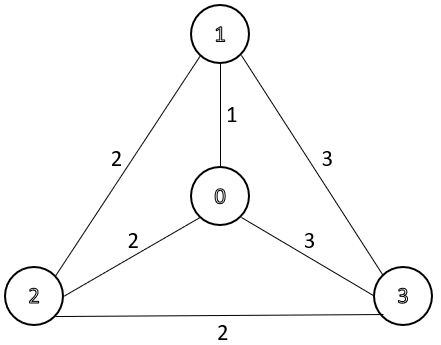

An optimal route is `[0, 1, 2, 3]`, with the minimal distance travelled of 1 + 2 + 2 + 3 = 8.

**Note:**
* There can be more than 1 shortest route, e.g., `[1, 0, 3, 2]`, `[1, 3, 2, 0]`, etc. You only need to find one such route.
* `[0, 1, 2]` is not legal as the route must go through all 4 cities.
* `[0, 1, 2, 3, 1]` is not legal as city 1 is visited more than once.
* `[1, 3, 0, 2]` is legal but it is not the shortest route, as the distance travelled of 3 + 3 + 2 + 2 = 10.

### Task 2.1: State representation
Propose a state representation for this problem if we want to formulate it as a local search problem.

### Task 2.2: Initial and goal states

What are the initial and goal states for the problem under your proposed representation?

**Note:**
* In many optimization problems such as the TSP, the path to the goal is irrelevant; **the goal state itself is the solution to the problem**.
* Local search algorithms keep a single "current" state and move from a state to another in the search space by applying local changes (with the help of a *transition function*), until an optimal solution is found.

### Can you do better?

Recall that similar to A* search, local search utilises evaluation functions to decide how to transition from one state to another. However, being an uninformed guy, your cousin Ben Bitdiddle tells you to use the "greedy" solution. Given an incomplete route, the "greedy" solution builds a path by adding the closest unvisited node from the last visited node, until all nodes are visited. For instance, in the graph above, the "greedy" solution is `[0, 1, 2, 3]`.

Although this solution seems relatively sensible, as a CS2109S student, you have a nagging feeling that it may not work all the time. Can you create an evaluation function and transition function to get better results with local search?


**Note:**

* For the following tasks, we will be benchmarking your hill-climbing algorithm against our own version using the greedy solution. Note that the hidden test cases can be quite large, so any brute-force solution will not suffice. 

* Your own evaluation functions and transition functions may underperform against the greedy solution for small instances of TSP, but should outperform the greedy solution consistently for large instances. For our public and private test cases, we have designed the greedy solution to be suboptimal.

* If your code does not pass the private test cases on Coursemology because it underperforms against the greedy solution, you may re-run your code a few times in case you are "unlucky" with random initial routes.

### Task 2.3: State transitions

Implement a reasonable transition function `transition(route)` to generate new routes by applying minor "tweaks" to the current route. It should return a list of new routes to be used in the next iteration in the hill-climbing algorithm.

**Note:**
* At each iteration, the routes generated from the transition function are evaluated against each other (using an evaluation function). The best route will be selected for the next iteration if it is better than the current route.
* Your transition function should not return too many routes as it would take too much time for evaluation. (do not enumerate all possible states otherwise it will timeout, only generate "neighbors")
* However, if too few routes are generated, you are more likely to be stuck at a local maxima as each route will be compared against fewer routes.

In [ ]:
def transition(route: List[int]):
    r"""
    Generates new routes to be used in the next iteration in the hill-climbing algorithm.

    Args:        
        route (List[int]): The current route as a list of cities in the order of travel

    Returns:
        new_routes (List[List[int]]): New routes to be considered
    """
    new_routes = []
    
    """ YOUR CODE HERE """
    
    """ END YOUR CODE HERE """

    return new_routes

In [ ]:
# Test case for Task 2.3
@wrap_test
def test_transition(route: List[int]):
    for new_route in transition(route):
        assert sorted(new_route) == list(range(len(route))), "Invalid route"

    return "PASSED"

print(test_transition([1, 3, 2, 0]))
print(test_transition([7, 8, 6, 3, 5, 4, 9, 2, 0, 1]))

### Task 2.4: Evaluation function
Implement an evaluation function `evaluation_func(cities, distances, route)` that would be helpful in deciding on the "goodness" of a route, i.e. an optimal route should return a higher evaluation score than a suboptimal one.

In [ ]:
def evaluation_func(cities: int, distances: List[Tuple[int]], route: List[int]) -> float:
    r"""
    Computes the evaluation score of a route

    Args:
        cities (int): The number of cities to be visited

        distances (List[Tuple[int]]): The list of distances between every two cities
            Each distance is represented as a tuple in the form of (c1, c2, d), where
                c1 and c2 are the two cities and d is the distance between them.
            The length of the list should be equal to cities * (cities - 1)/2.

        route (List[int]): The current route as a list of cities in the order of travel

    Returns:
        h_n (float): the evaluation score
    """
    h_n = 0.0
    
    """ YOUR CODE HERE """
    
    """ END YOUR CODE HERE """

    return h_n

In [ ]:
# Test case for Task 2.4
cities = 4
distances = [(1, 0, 10), (0, 3, 22), (2, 1, 8), (2, 3, 30), (1, 3, 25), (0, 2, 15)]

route_1 = evaluation_func(cities, distances, [0, 1, 2, 3])
route_2 = evaluation_func(cities, distances, [2, 1, 3, 0])
route_3 = evaluation_func(cities, distances, [1, 3, 2, 0])

print(route_1 == route_2)  # True
print(route_1 > route_3)  # True

### Task 2.5: Explain your evaluation function

Explain why your evaluation function is suitable for this problem. 

### Task 2.6: Implement hill-climbing
Using your representation above, implement the hill-climbing algorithm `hill_climbing(cities, distances)`, which takes in the number of cities and the list of distances, and returns the shortest route as a list of cities.

1. The hill-climbing approach is a local search algorithm which starts with a randomly-initialised state and continuously selects the next candidate solution that locally maximizes the reduction of the evaluation function.

2. The algorithm terminates when a (local) maxima is reached, i.e. a solution that cannot be improved further by looking at the next candidate solutions.

3. Unlike previous search algorithms you have implemented, hill-climbing only keeps a single current state. As such, it does not involve a search tree/graph. Backtracking is also not possible.

An implementation for `evaluation_func(cities, distances, route)` has been provided on Coursemology for this section, in case you were unable to come up with a good evaluation function and transition function. Locally, you can test your hill-climbing implementation using the functions you defined in Task 2.3.

In [ ]:
def hill_climbing(cities: int, distances: List[Tuple[int]]):
    r"""
    Hill climbing finds the solution to reach the goal from the initial.

    Args:
        cities (int): The number of cities to be visited

        distances (List[Tuple[int]]): The list of distances between every two cities
            Each distance is represented as a tuple in the form of (c1, c2, d), where
                c1 and c2 are the two cities and d is the distance between them.
            The length of the list should be equal to cities * (cities - 1)/2.

    Returns:
        route (List[int]): The shortest route, represented by a list of cities
            in the order to be traversed.
    """

    route = []

    """ YOUR CODE HERE """

    """ END YOUR CODE HERE """

    return route

In [ ]:
# Test cases for Task 2.3, 2.5, 2.6
@wrap_test
def test_hill_climbing(cities: int, distances: List[Tuple[int]]):
    start = time.time()
    route = hill_climbing(cities, distances)
    print(f"Time lapsed: {time.time() - start}")

    assert sorted(route) == list(range(cities)), "Invalid route"

    return "PASSED"

cities_1 = 4
distances_1 = [(1, 0, 10), (0, 3, 22), (2, 1, 8), (2, 3, 30), (1, 3, 25), (0, 2, 15)]

cities_2 = 10
distances_2 = [(2, 7, 60), (1, 6, 20), (5, 4, 70), (9, 8, 90), (3, 7, 54), (2, 5, 61),
    (4, 1, 106), (0, 6, 51), (3, 1, 45), (0, 5, 86), (9, 2, 73), (8, 4, 14), (0, 1, 51),
    (9, 7, 22), (3, 2, 22), (8, 1, 120), (5, 7, 92), (5, 6, 60), (6, 2, 10), (8, 3, 78),
    (9, 6, 82), (0, 2, 41), (2, 8, 99), (7, 8, 71), (0, 9, 32), (4, 0, 73), (0, 3, 42),
    (9, 1, 80), (4, 2, 85), (5, 9, 113), (3, 6, 28), (5, 8, 81), (3, 9, 72), (9, 4, 81),
    (5, 3, 45), (7, 4, 60), (6, 8, 106), (0, 8, 85), (4, 6, 92), (7, 6, 70), (7, 0, 22),
    (7, 1, 73), (4, 3, 64), (5, 1, 80), (2, 1, 22)]

print('cities_1: ' + test_hill_climbing(cities_1, distances_1))
print('cities_2: ' + test_hill_climbing(cities_2, distances_2))

### Task 2.7: Improve hill-climbing with random restarts

When no "better" neighbouring solutions are present, local search can be stuck at a local maxima. One way to combat this is to simply repeat local search from random initial states, taking the best performing iteration. 

Implement `hill_climbing_with_random_restarts(cities, distances, repeats)` by repeating hill climbing at different random locations.

* Implementations for `evaluation_func(cities, distances, route)` and `hill_climbing(cities, distances)` has been provided on Coursemology for this section, but you can redefine it with your own version if you wish.
* Note that the implemented `evaluation_func(cities, distances, route)` returns a float, which can be from `float(-inf)` to `float(inf)`.

In [ ]:
def hill_climbing_with_random_restarts(cities: int, distances: List[Tuple[int]], repeats: int = 10):
    r"""
    Hill climbing with random restarts finds the solution to reach the goal from the initial.

    Args:
        cities (int): The number of cities to be visited

        distances (List[Tuple[int]]): The list of distances between every two cities
            Each distance is represented as a tuple in the form of (c1, c2, d), where
                c1 and c2 are the two cities and d is the distance between them.
            The length of the list should be equal to cities * (cities - 1)/2.

        repeats (int): The number of times hill climbing to be repeated. The default
            value is 10.

    Returns:
        route (List[int]): The shortest route, represented by a list of cities
            in the order to be traversed.
    """

    route = []

    """ YOUR CODE HERE """

    """ END YOUR CODE HERE """

    return route

In [ ]:
# Test cases for Task 2.7
@wrap_test
def test_random_restarts(cities: int, distances: List[Tuple[int]], repeats: int = 10):
    start = time.time()
    route = hill_climbing_with_random_restarts(cities, distances, repeats)
    print(f"Time lapsed: {time.time() - start}")

    assert sorted(route) == list(range(cities)), "Invalid route"

    return "PASSED"

cities_1 = 4
distances_1 = [(1, 0, 10), (0, 3, 22), (2, 1, 8), (2, 3, 30), (1, 3, 25), (0, 2, 15)]

cities_2 = 10
distances_2 = [(2, 7, 60), (1, 6, 20), (5, 4, 70), (9, 8, 90), (3, 7, 54), (2, 5, 61),
    (4, 1, 106), (0, 6, 51), (3, 1, 45), (0, 5, 86), (9, 2, 73), (8, 4, 14), (0, 1, 51),
    (9, 7, 22), (3, 2, 22), (8, 1, 120), (5, 7, 92), (5, 6, 60), (6, 2, 10), (8, 3, 78),
    (9, 6, 82), (0, 2, 41), (2, 8, 99), (7, 8, 71), (0, 9, 32), (4, 0, 73), (0, 3, 42),
    (9, 1, 80), (4, 2, 85), (5, 9, 113), (3, 6, 28), (5, 8, 81), (3, 9, 72), (9, 4, 81),
    (5, 3, 45), (7, 4, 60), (6, 8, 106), (0, 8, 85), (4, 6, 92), (7, 6, 70), (7, 0, 22),
    (7, 1, 73), (4, 3, 64), (5, 1, 80), (2, 1, 22)]

print('cities_1: ' + test_random_restarts(cities_1, distances_1))
print('cities_2: ' + test_random_restarts(cities_2, distances_2, 20))

### Task 2.8: Comparison between local search and other search algorithms

Compared to previous search algorithms you have seen (uninformed search, A*), why do you think local search is more suitable for this problem?

## Test Cases

To help with your implementation, we have provided some examples as test cases. These are not sufficient to ensure that your code is works correctly, and we encourage you to write your own additional test cases to test and debug your code.

Note that your answers may be slightly different from the answers provided since multiple valid solutions sharing the same cost may exist. During grading, your code will be evaluated on hidden test cases on top of the ones we have provided. We will validate your solution and compare the resulting cost to the expected optimal cost.

Also note that we will have hidden test case(s) to check the quality of your heuristic functions in the A* search and local search algorithms. Basically, a good heuristic function should provide valuable information to the search, and thus it reduces the number of explorations before finding the best solution. You can keep track of the size of the “reached” state to help you design a better heuristic.

<center><i>Have fun and enjoy coding.<i><center>

# Submission

Once you are done, please submit your work to Coursemology, by copying the right snippets of code into the corresponding box that says 'Your answer', and click 'Save'.  After you save, you can make changes to your
submission.

Once you are satisfied with what you have uploaded, click 'Finalize submission.'  **Note that once your submission is finalized, it is considered to be submitted for grading and cannot be changed**. If you need to undo
this action, you will have to email your assigned tutor for help. Please do not finalize your submission until you are sure that you want to submit your solutions for grading. 
